## Fitting GP with NUTS Sampling - 1 dataset

Running MCMC...


Warmup [1]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1500 [00:00, ?it/s]

/opt/conda/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


MCMC Diagnostics:
                    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
kernel_variance     1.82  0.51    1.00     2.74       0.02     0.01   1188.16   
kernel_lengthscale  0.06  0.01    0.05     0.07       0.00     0.00   1466.99   

                    ess_tail  r_hat  
kernel_variance       890.80    1.0  
kernel_lengthscale   1204.96    1.0  


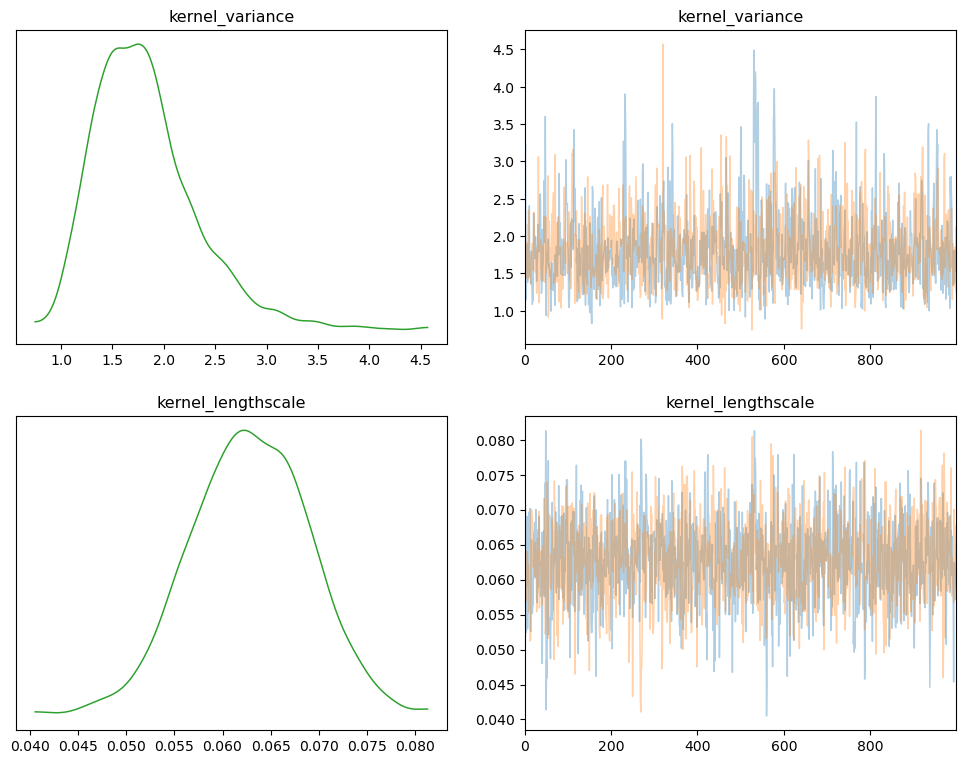


Effective Sample Size (ESS):
kernel_variance       1188.16
kernel_lengthscale    1466.99
Name: ess_bulk, dtype: float64

R-hat:
kernel_variance       1.0
kernel_lengthscale    1.0
Name: r_hat, dtype: float64
Log Likelihood of the Test Data: -0.881
Test Log Likelihood: -0.881
Final Kernel Variance: 1.821
Final Kernel Lengthscale: 0.063


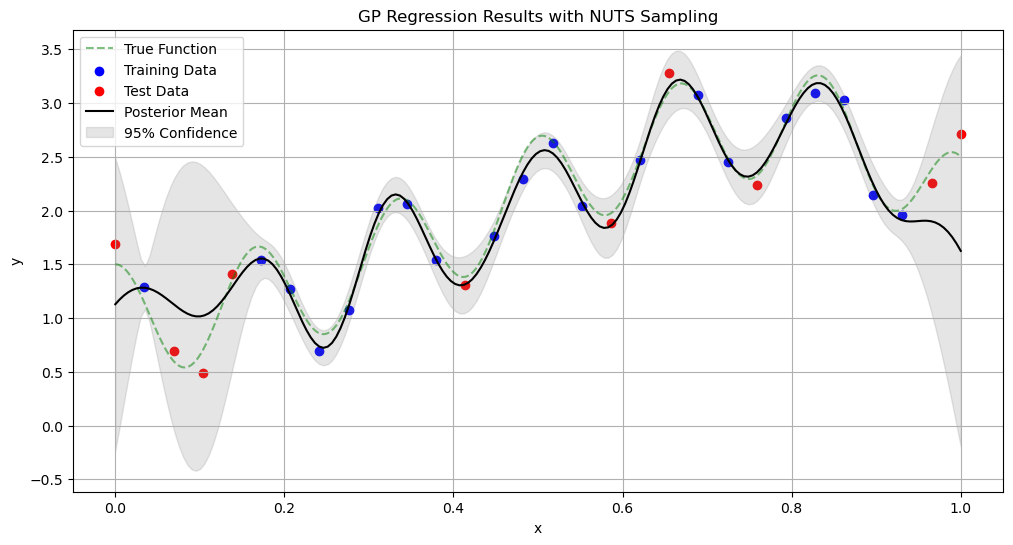

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC
import arviz as az

pyro.clear_param_store()

seed_value = 42
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
np.random.seed(seed_value)

# GP Class Definition
class GP:
    def __init__(self, noise_variance=0.01):
        self.noise_variance = torch.tensor(noise_variance)  # Fixed noise variance

    def kernel(self, x1: torch.Tensor, x2: torch.Tensor = None, kernel_variance=None, kernel_lengthscale=None) -> torch.Tensor:
        if x2 is None:
            x2 = x1
        x1, x2 = x1.reshape(-1, 1), x2.reshape(-1, 1)
        dist_matrix = (x1 - x2.T)**2
        return kernel_variance * torch.exp(-0.5 * dist_matrix / kernel_lengthscale**2)

    def model(self, x_train, y_train):
        # Priors for kernel parameters
        kernel_variance = pyro.sample("kernel_variance", dist.LogNormal(-0.64, 0.5))
        kernel_lengthscale = pyro.sample("kernel_lengthscale", dist.LogNormal(-2.94, 0.5))
        
        # Compute kernel matrix
        K = self.kernel(x_train, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale) + \
            self.noise_variance * torch.eye(len(x_train), device=x_train.device)
        
        # Multivariate Normal for observations
        pyro.sample("obs", dist.MultivariateNormal(torch.zeros(len(x_train)), covariance_matrix=K), obs=y_train)

    def predict_and_log_likelihood(self, x_train, y_train, x_test, y_test, posterior_samples):
        # Compute predictive mean and variance using posterior samples
        kernel_variance = posterior_samples["kernel_variance"].mean()
        kernel_lengthscale = posterior_samples["kernel_lengthscale"].mean()

        # Compute kernel matrices
        K = self.kernel(x_train, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale) + \
            self.noise_variance * torch.eye(len(x_train), device=x_train.device)
        K_star = self.kernel(x_train, x_test, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale)
        K_star_star = self.kernel(x_test, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale)

        # Cholesky decomposition
        L = torch.linalg.cholesky(K)
        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))
        
        # Predictive mean and variance for test points
        mean = K_star.T @ alpha
        v = torch.linalg.solve(L, K_star)
        var = K_star_star - v.T @ v
        var = var.diagonal()
        
        # Ensure broadcasting matches for test log likelihood
        mean = mean.squeeze()
        std = torch.sqrt(var)
        log_likelihood = torch.sum(torch.distributions.Normal(mean, std).log_prob(y_test))
        
        return mean, var, log_likelihood

# Helper Functions
def generate_data(n_points=30):
    x = torch.linspace(0, 1, n_points)
    y_true = -(torch.sin(6 * np.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3/2
    y = y_true + torch.normal(0, np.sqrt(0.01), size=y_true.shape)
    return x, y

def plot_gp_fit_with_mcmc(gp, x_train, y_train, x_test, y_test, posterior_samples):
    x_pred = torch.linspace(0, 1, 200)
    mean_pred, var_pred, _ = gp.predict_and_log_likelihood(x_train, y_train, x_pred, y_test[:1], posterior_samples)
    mean_test, var_test, log_likelihood = gp.predict_and_log_likelihood(x_train, y_train, x_test, y_test, posterior_samples)
    std_pred = torch.sqrt(var_pred)

    print(f"Test Log Likelihood: {log_likelihood:.3f}")

    # Print final kernel parameters
    kernel_variance = posterior_samples["kernel_variance"].mean().item()
    kernel_lengthscale = posterior_samples["kernel_lengthscale"].mean().item()
    print(f"Final Kernel Variance: {kernel_variance:.3f}")
    print(f"Final Kernel Lengthscale: {kernel_lengthscale:.3f}")

    plt.figure(figsize=(12, 6))

    # Plot true function
    x_true = torch.linspace(0, 1, 1000)
    y_true = -(torch.sin(6 * np.pi * x_true))**2 + 6 * x_true**2 - 5 * x_true**4 + 3/2
    plt.plot(x_true, y_true, 'g--', alpha=0.5, label='True Function')

    # Plot data points
    plt.scatter(x_train, y_train, c='blue', label='Training Data')
    plt.scatter(x_test, y_test, c='red', label='Test Data')

    # Plot GP prediction
    plt.plot(x_pred, mean_pred.detach(), 'k-', label='Posterior Mean')
    plt.fill_between(
        x_pred.numpy(),
        (mean_pred - 2 * std_pred).detach().numpy(),
        (mean_pred + 2 * std_pred).detach().numpy(),
        color='gray',
        alpha=0.2,
        label='95% Confidence'
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('GP Regression Results with NUTS Sampling')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_diagnostics(idata):
    az.plot_trace(idata, var_names=["kernel_variance", "kernel_lengthscale"], compact=False, figsize=(10, 8), combined=True)
    plt.tight_layout(pad=2.0)
    plt.show()

# Generate one dataset
x, y = generate_data(n_points=30)
indices = torch.randperm(len(x))
train_indices = indices[:20]
test_indices = indices[20:]

x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]

# Initialize the GP model
gp = GP()

# Initial NUTS sampling parameters
nuts_kernel = NUTS(gp.model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=500, num_chains=2)
print("Running MCMC...")
mcmc.run(x_train, y_train)

# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Convert to ArviZ InferenceData for diagnostics
idata = az.from_pyro(mcmc)

# Diagnostics
print("MCMC Diagnostics:")
summary = az.summary(idata, var_names=["kernel_variance", "kernel_lengthscale"], round_to=2)
print(summary)

# Plot diagnostics
plot_diagnostics(idata)

# Check effective sample size and R-hat
ess = summary.loc[:, "ess_bulk"]
rhat = summary.loc[:, "r_hat"]

print("\nEffective Sample Size (ESS):")
print(ess)
print("\nR-hat:")
print(rhat)

# Adjust MCMC parameters if needed
if any(rhat > 1.01):
    print("\nWarning: R-hat values indicate lack of convergence. Consider increasing warmup steps.")
if any(ess < 100):
    print("\nWarning: ESS is low. Consider increasing the number of samples.")

# Compute predictions and log likelihood
mean, var, log_likelihood = gp.predict_and_log_likelihood(x_train, y_train, x_test, y_test, posterior_samples)

# Display results
print(f"Log Likelihood of the Test Data: {log_likelihood:.3f}")

# Plot predictions
plot_gp_fit_with_mcmc(gp, x_train, y_train, x_test, y_test, posterior_samples)

## ArviZ Diagnostics

------------------------------Summary Statistics:-----------------------------
                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel_lengthscale  0.063  0.006   0.052    0.074      0.000    0.000   
kernel_variance     1.821  0.505   1.004    2.737      0.016    0.012   

                    ess_bulk  ess_tail  r_hat  
kernel_lengthscale    1467.0    1205.0    1.0  
kernel_variance       1188.0     891.0    1.0  


/opt/conda/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


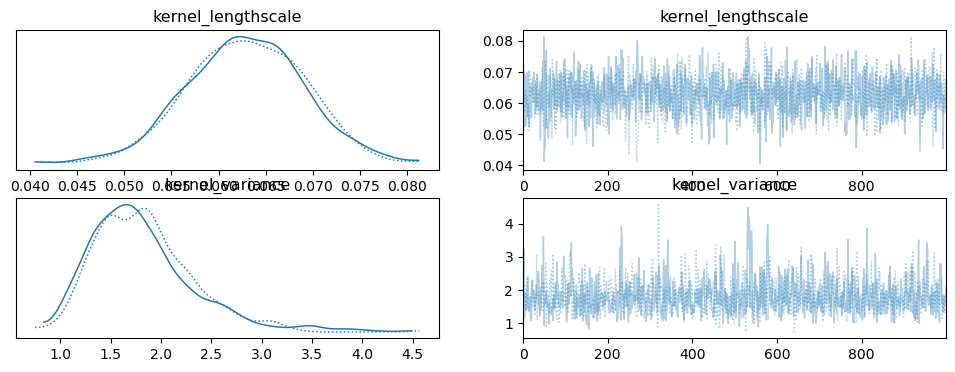

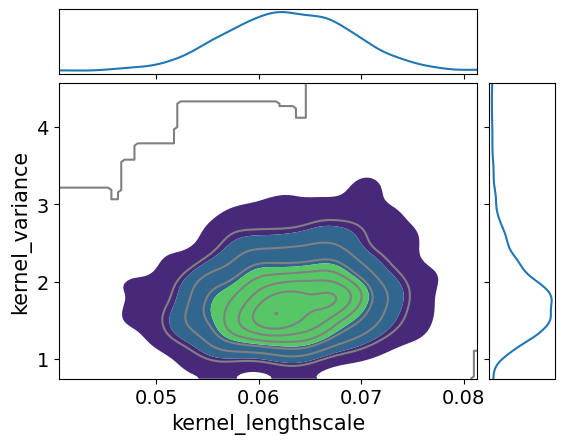

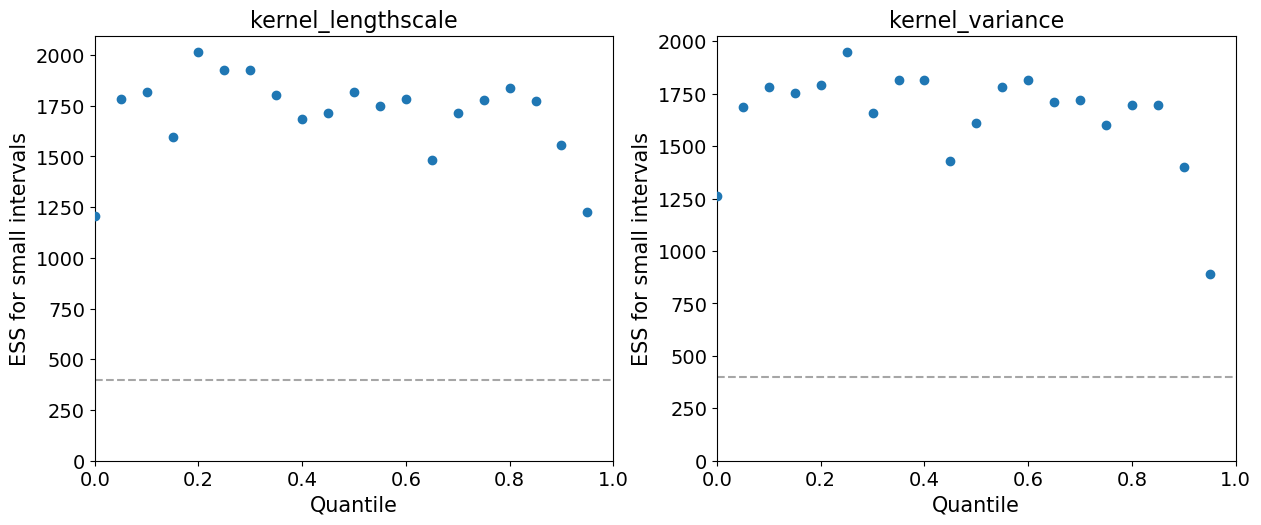

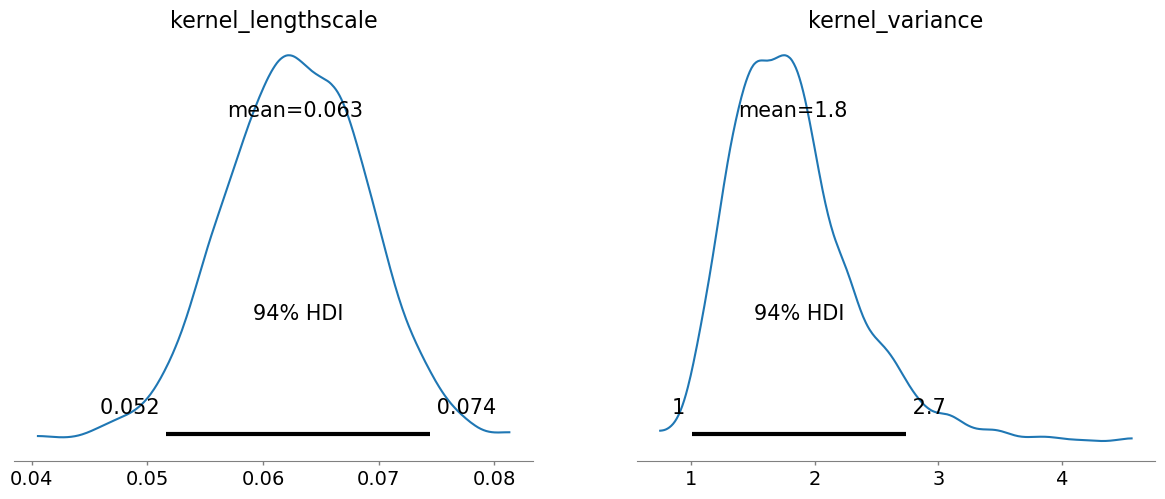

In [2]:
# Convert Pyro samples to ArviZ InferenceData
idata = az.from_pyro(mcmc)

print('------------------------------Summary Statistics:-----------------------------')
summary = az.summary(idata)
print(summary)

# Trace plot to check chain mixing
az.plot_trace(idata)
plt.show()

# Pair plot to check parameter relationships
az.plot_pair(idata, kind="kde", marginals=True)
plt.show()

# Plot effective sample size (ESS)
az.plot_ess(idata)
plt.show()

az.plot_posterior(idata)
plt.show()

## Likelihood over 500 samples theta values 

In [3]:
# Compute the approximate posterior likelihood of the test set

def compute_posterior_likelihood(gp, x_train, y_train, x_test, y_test, posterior_samples, num_samples=500):
    # Ensure we don't exceed the available number of samples
    available_samples = len(posterior_samples["kernel_variance"])
    num_samples = min(num_samples, available_samples)
    
    total_log_likelihood = 0.0

    # Use only the first `num_samples` posterior samples
    for i in range(num_samples):
        # Extract one set of sampled parameters
        kernel_variance = posterior_samples["kernel_variance"][i]
        kernel_lengthscale = posterior_samples["kernel_lengthscale"][i]

        # Compute the GP posterior predictive mean and variance for the test set
        K = gp.kernel(x_train, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale) + \
            gp.noise_variance * torch.eye(len(x_train), device=x_train.device)
        K_star = gp.kernel(x_train, x_test, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale)
        K_star_star = gp.kernel(x_test, kernel_variance=kernel_variance, kernel_lengthscale=kernel_lengthscale)

        # Cholesky decomposition
        L = torch.linalg.cholesky(K)
        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))

        # Predictive mean and variance for test points
        mean = K_star.T @ alpha
        v = torch.linalg.solve(L, K_star)
        var = K_star_star - v.T @ v
        var = var.diagonal()

        # Compute log likelihood for the test set
        std = torch.sqrt(var)
        log_likelihood = torch.sum(torch.distributions.Normal(mean.squeeze(), std).log_prob(y_test))

        # Accumulate log likelihood
        total_log_likelihood += log_likelihood.item()

        # Print progress every 50 samples
        if (i + 1) % 50 == 0 or i == num_samples - 1:
            print(f"Processed {i + 1}/{num_samples} samples. Current cumulative log likelihood: {total_log_likelihood:.3f}")

    # Compute the average posterior likelihood
    average_log_likelihood = total_log_likelihood / num_samples

    return average_log_likelihood

# Call the function
average_log_likelihood = compute_posterior_likelihood(
    gp, x_train, y_train, x_test, y_test, posterior_samples, num_samples=500
)

# Print the result
print("")
print(f"Average Posterior Log Likelihood of the Test Set: {average_log_likelihood:.3f}")

Processed 50/500 samples. Current cumulative log likelihood: -85.354
Processed 100/500 samples. Current cumulative log likelihood: -184.853
Processed 150/500 samples. Current cumulative log likelihood: -284.215
Processed 200/500 samples. Current cumulative log likelihood: -381.081
Processed 250/500 samples. Current cumulative log likelihood: -469.293
Processed 300/500 samples. Current cumulative log likelihood: -553.139
Processed 350/500 samples. Current cumulative log likelihood: -620.420
Processed 400/500 samples. Current cumulative log likelihood: -715.884
Processed 450/500 samples. Current cumulative log likelihood: -801.757
Processed 500/500 samples. Current cumulative log likelihood: -882.894

Average Posterior Log Likelihood of the Test Set: -1.766


## Fitting GP with NUTS Sampling - 20 datasets

Starting dataset 1/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:31, 31.79it/s, step size=8.25e-01, acc. prob=0.929]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:32, 31.10it/s, step size=6.17e-01, acc. prob=0.928]


Dataset 1 complete with likelihood: -12.338
Starting dataset 2/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:31, 31.28it/s, step size=8.42e-01, acc. prob=0.918]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:32, 31.06it/s, step size=6.44e-01, acc. prob=0.930]


Dataset 2 complete with likelihood: -8.269
Starting dataset 3/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:30, 32.41it/s, step size=8.59e-01, acc. prob=0.915]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:30, 32.43it/s, step size=6.93e-01, acc. prob=0.915]


Dataset 3 complete with likelihood: -1.194
Starting dataset 4/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:31, 31.60it/s, step size=7.72e-01, acc. prob=0.880]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:34, 28.66it/s, step size=6.96e-01, acc. prob=0.920]


Dataset 4 complete with likelihood: 2.432
Starting dataset 5/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:33, 29.68it/s, step size=7.43e-01, acc. prob=0.933]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:33, 29.42it/s, step size=7.72e-01, acc. prob=0.910]


Dataset 5 complete with likelihood: -5.170
Starting dataset 6/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:38, 25.98it/s, step size=6.67e-01, acc. prob=0.941]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:38, 26.18it/s, step size=5.77e-01, acc. prob=0.945]


Dataset 6 complete with likelihood: -0.924
Starting dataset 7/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:34, 29.01it/s, step size=7.51e-01, acc. prob=0.890]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:40, 24.73it/s, step size=5.82e-01, acc. prob=0.944]


Dataset 7 complete with likelihood: 4.142
Starting dataset 8/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:39, 25.21it/s, step size=8.32e-01, acc. prob=0.896]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:40, 24.52it/s, step size=6.16e-01, acc. prob=0.951]


Dataset 8 complete with likelihood: -8.851
Starting dataset 9/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:31, 31.67it/s, step size=7.22e-01, acc. prob=0.909]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:38, 26.01it/s, step size=5.94e-01, acc. prob=0.943]


Dataset 9 complete with likelihood: 3.897
Starting dataset 10/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:36, 27.33it/s, step size=7.22e-01, acc. prob=0.916]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:40, 24.72it/s, step size=7.75e-01, acc. prob=0.923]


Dataset 10 complete with likelihood: 3.364
Starting dataset 11/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:39, 25.19it/s, step size=7.15e-01, acc. prob=0.928]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:34, 29.00it/s, step size=5.92e-01, acc. prob=0.932]


Dataset 11 complete with likelihood: -0.215
Starting dataset 12/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:38, 26.09it/s, step size=8.34e-01, acc. prob=0.935]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:36, 27.63it/s, step size=7.30e-01, acc. prob=0.907]


Dataset 12 complete with likelihood: -10.814
Starting dataset 13/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:34, 29.35it/s, step size=6.37e-01, acc. prob=0.931]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:35, 27.97it/s, step size=7.55e-01, acc. prob=0.916]


Dataset 13 complete with likelihood: -3.272
Starting dataset 14/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:31, 31.29it/s, step size=8.93e-01, acc. prob=0.866]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:34, 29.29it/s, step size=6.05e-01, acc. prob=0.940]


Dataset 14 complete with likelihood: -1.299
Starting dataset 15/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:32, 30.59it/s, step size=8.12e-01, acc. prob=0.911]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:31, 31.40it/s, step size=8.24e-01, acc. prob=0.906]


Dataset 15 complete with likelihood: -2.169
Starting dataset 16/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:35, 28.17it/s, step size=6.84e-01, acc. prob=0.942]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:36, 27.70it/s, step size=8.50e-01, acc. prob=0.923]


Dataset 16 complete with likelihood: -7.723
Starting dataset 17/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:37, 26.64it/s, step size=7.55e-01, acc. prob=0.890]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:34, 29.04it/s, step size=1.01e+00, acc. prob=0.856]


Dataset 17 complete with likelihood: -0.664
Starting dataset 18/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:36, 27.09it/s, step size=7.95e-01, acc. prob=0.891]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:40, 24.77it/s, step size=6.83e-01, acc. prob=0.946]


Dataset 18 complete with likelihood: -0.653
Starting dataset 19/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:41, 24.37it/s, step size=8.27e-01, acc. prob=0.878]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:45, 21.92it/s, step size=6.93e-01, acc. prob=0.929]


Dataset 19 complete with likelihood: 4.196
Starting dataset 20/20...
Running chain 1/2...


Sample: 100%|██████████| 1000/1000 [00:43, 22.81it/s, step size=7.06e-01, acc. prob=0.948]


Running chain 2/2...


Sample: 100%|██████████| 1000/1000 [00:34, 29.01it/s, step size=6.87e-01, acc. prob=0.935]

Dataset 20 complete with likelihood: -1.379

Results across 20 datasets:
Mean Log Likelihood: -2.345 ± 4.907
Mean Kernel Variance: 1.842 ± 0.100
Mean Kernel Lengthscale: 0.066 ± 0.002


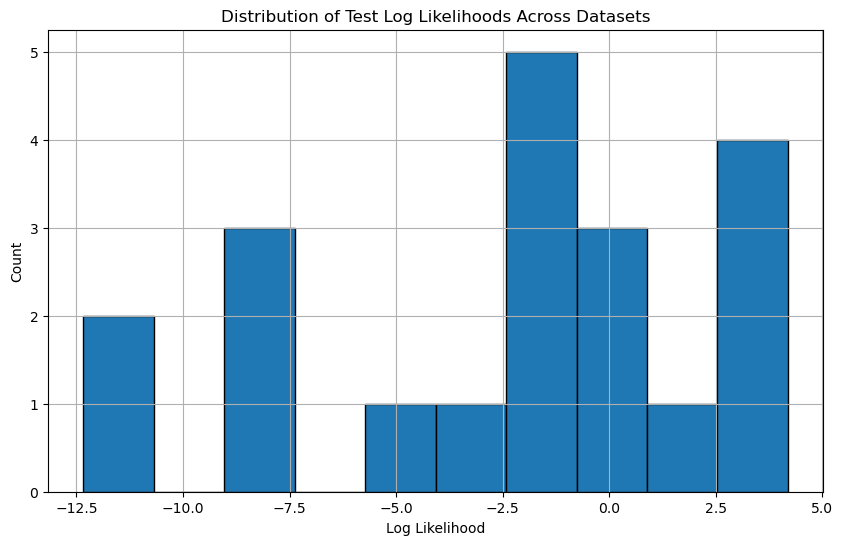


Running final MCMC with mean hyperparameters...
Final test log likelihood with mean hyperparameters: 4.514
Test Log Likelihood: 4.514
Final Kernel Variance: 1.842
Final Kernel Lengthscale: 0.066


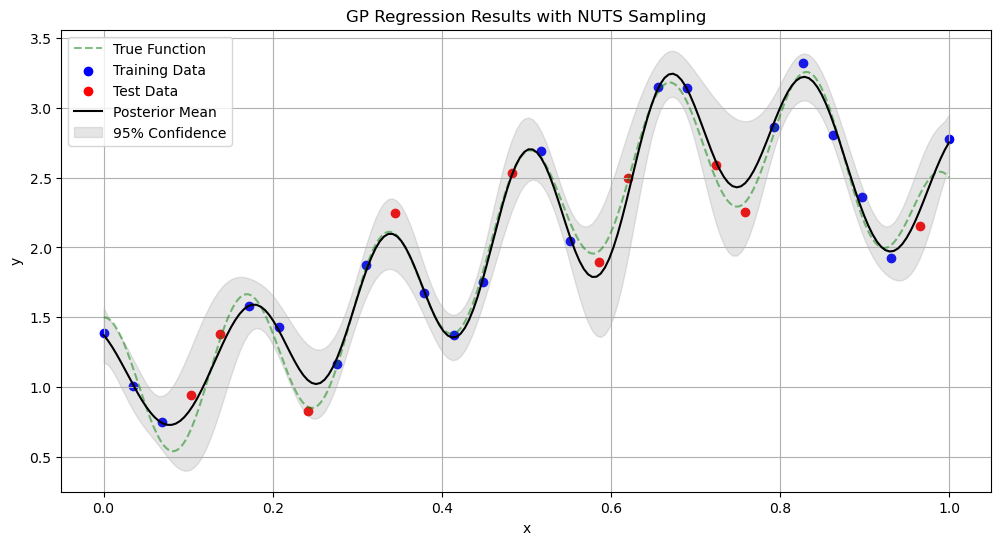

In [15]:
def mcmc_likelihood_comparison(gp, num_datasets=20, num_samples=500):
    mcmc_likelihoods = []
    all_hyperparameters = {'kernel_variance': [], 'kernel_lengthscale': []}
    
    for i in range(num_datasets):
        print(f"Starting dataset {i + 1}/{num_datasets}...")
        
        # Clear memory and cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        pyro.clear_param_store()
        
        # Generate and split data
        x, y = generate_data()
        indices = torch.randperm(len(x))
        train_indices = indices[:20]
        test_indices = indices[20:]
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        
        # Run chains sequentially
        all_samples = {}
        for chain in range(2):
            print(f"Running chain {chain + 1}/2...")
            pyro.clear_param_store()
            nuts_kernel = NUTS(gp.model)
            mcmc = MCMC(nuts_kernel, 
                       num_samples=500,
                       warmup_steps=500,
                       num_chains=1)
            
            try:
                mcmc.run(x_train, y_train)
                chain_samples = mcmc.get_samples()
                
                # Initialize or update all_samples
                if not all_samples:
                    all_samples = {k: v for k, v in chain_samples.items()}
                else:
                    for k in chain_samples:
                        all_samples[k] = torch.cat([all_samples[k], chain_samples[k]])
                
                mcmc = None
                nuts_kernel = None
                
            except Exception as e:
                print(f"Error in chain {chain + 1}: {str(e)}")
                continue
        
        # Save hyperparameters
        all_hyperparameters['kernel_variance'].append(all_samples['kernel_variance'].mean().item())
        all_hyperparameters['kernel_lengthscale'].append(all_samples['kernel_lengthscale'].mean().item())
        
        # Compute likelihood
        try:
            _, _, likelihood_mcmc = gp.predict_and_log_likelihood(
                x_train, y_train, x_test, y_test, all_samples
            )
            mcmc_likelihoods.append(likelihood_mcmc.item())
            print(f"Dataset {i + 1} complete with likelihood: {likelihood_mcmc:.3f}")
            
        except Exception as e:
            print(f"Error in likelihood computation: {str(e)}")
            continue
            
    return mcmc_likelihoods, all_hyperparameters

# Run for 20 datasets
mcmc_likelihoods, all_hyperparameters = mcmc_likelihood_comparison(gp, num_datasets=20)

# Calculate statistics
mean_likelihood = np.mean(mcmc_likelihoods)
std_likelihood = np.std(mcmc_likelihoods)
mean_variance = np.mean(all_hyperparameters['kernel_variance'])
mean_lengthscale = np.mean(all_hyperparameters['kernel_lengthscale'])
std_variance = np.std(all_hyperparameters['kernel_variance'])
std_lengthscale = np.std(all_hyperparameters['kernel_lengthscale'])

print("\nResults across 20 datasets:")
print(f"Mean Log Likelihood: {mean_likelihood:.3f} ± {std_likelihood:.3f}")
print(f"Mean Kernel Variance: {mean_variance:.3f} ± {std_variance:.3f}")
print(f"Mean Kernel Lengthscale: {mean_lengthscale:.3f} ± {std_lengthscale:.3f}")

# Plot likelihood distribution
plt.figure(figsize=(10, 6))
plt.hist(mcmc_likelihoods, bins=10, edgecolor='black')
plt.title("Distribution of Test Log Likelihoods Across Datasets")
plt.xlabel("Log Likelihood")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Now run a single MCMC with mean hyperparameters
print("\nRunning final MCMC with mean hyperparameters...")
# Generate new test data
x, y = generate_data()
indices = torch.randperm(len(x))
train_indices = indices[:20]
test_indices = indices[20:]
x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]

# Create samples dictionary with mean hyperparameters
mean_samples = {
    'kernel_variance': torch.tensor([mean_variance]),
    'kernel_lengthscale': torch.tensor([mean_lengthscale])
}

# Compute prediction and likelihood
mean_pred, var_pred, final_likelihood = gp.predict_and_log_likelihood(
    x_train, y_train, x_test, y_test, mean_samples
)

print(f"Final test log likelihood with mean hyperparameters: {final_likelihood:.3f}")

# Plot final fit
plot_gp_fit_with_mcmc(gp, x_train, y_train, x_test, y_test, mean_samples)